# Overview

Example of loading text data and metadata in Python and visualizing some interactions between patterns in metadata and text (simple word frequencies).

The text data is organized as text files in directories. The metadata for documents in the corpus is in a CSV file.

# Load data

In [1]:
# Read in metadata as a dictionary of pandas dataframes

import os
import pandas as pd

# pandas display settings
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 10000)

metadata_dirpath = '/usr2/scratch/fanfic/'

fandoms = [
    'allmarvel',
    'dcu',
    'harrypotter',
    'sherlock',
    'starwars',
    'song_ice_fire',
    'supernatural',
    'teenwolf',
]


metadata = {}
for fandom in fandoms:
    metadata_fpath = os.path.join(metadata_dirpath, f'ao3_{fandom}_text', 'stories.csv')
    metadata[fandom] = pd.read_csv(metadata_fpath)

metadata['allmarvel']

,fic_id,title,author,author_key,rating,category,fandom,relationship,character,additional tags,language,published,status,status date,words,comments,kudos,bookmarks,hits,chapter_count,series,seriespart,seriesid
0,1000010,Bellwether,kaige68,kaige68,"[""General Audiences""]","[""M/M""]","[""The Avengers (Marvel Movies)"", ""Agents of S.H.I.E.L.D. (TV)""]","[""Clint Barton/Phil Coulson""]","[""Clint Barton"", ""Phil Coulson""]","[""Drabble"", ""Community: 1_million_words""]",English,2013-10-05,Completed,NaN,100.0,2.0,27.0,1.0,707.0,1,NaN,NaN,NaN
1,1000013,Estrella Nuclear,Badguy_x_Moores,Badguy_x_Moores,"[""Explicit""]","[""M/M""]","[""The Avengers (Marvel Movies)""]","[""Loki/Tony Stark""]","[""Loki (Marvel)"", ""Tony Stark""]","[""Romance"", ""Sex"", ""Slash""]",Español,2013-10-11,Completed,NaN,5037.0,NaN,6.0,NaN,378.0,1,NaN,NaN,NaN
2,1000017,Don't Let Go,helens78,helens78,"[""Teen And Up Audiences""]","[""M/M""]","[""X-Men: First Class (2011) - Fandom""]","[""Erik Lehnsherr/Charles Xavier""]","[""Erik Lehnsherr"", ""Charles Xavier"", ""Kurt Marko""]","[""Community: fan_flashworks"", ""Violence"", ""Alternate Universe - Role Reversal"", ""Role Reversal"", ""First Meetings"", ""Revenge"", ""Childhood Trauma""]",English,2013-09-06,Completed,NaN,1187.0,13.0,229.0,37.0,2497.0,1,NaN,NaN,NaN
3,1000018,You're All I Want (My Fantasy),helens78,helens78,"[""General Audiences""]","[""M/M""]","[""X-Men: First Class (2011) - Fandom""]","[""Erik Lehnsherr/Charles Xavier""]","[""Erik Lehnsherr"", ""Charles Xavier""]","[""Community: fan_flashworks"", ""Epic Bromance World Tour"", ""Gay Mutant Road Trip"", ""Photographs"", ""1960s"", ""Gay and Mutant in the 1960s"", ""Podfic Available""]",English,2013-10-11,Completed,NaN,598.0,2.0,107.0,17.0,1388.0,1,NaN,NaN,NaN
4,1000019,No Expectations,helens78,helens78,"[""Explicit""]","[""M/M""]","[""X-Men: First Class (2011) - Fandom""]","[""Erik Lehnsherr/Charles Xavier""]","[""Erik Lehnsherr"", ""Charles Xavier""]","[""Community: fan_flashworks"", ""Shower Sex"", ""Masturbation in Shower"", ""First Time"", ""Resolved Sexual Tension""]",English,2013-10-11,Completed,NaN,807.0,5.0,496.0,51.0,6522.0,1,NaN,NaN,NaN
5,1000020,Learning To Call You Home,helens78,helens78,"[""Mature""]","[""M/M""]","[""X-Men: First Class (2011) - Fandom""]","[""Erik Lehnsherr/Charles Xavier""]","[""Erik Lehnsherr"", ""Charles Xavier"", ""Hank McCoy"", ""Logan (X-Men)"", ""Ororo Munroe"", ""Jean Grey"", ""Scott Summers""]","[""Community: fan_flashworks"", ""Reverse Chronology"", ""Starting Over"", ""Canon Disabled Character"", ""Post-Canon"", ""Angst"", ""Implied/Referenced Mind Control"", ""Community: hc_bingo"", ""Hurt/Comfort""]",English,2013-10-11,Completed,NaN,907.0,4.0,121.0,12.0,1882.0,1,NaN,NaN,NaN
6,1000036,Bestow,kaige68,kaige68,"[""General Audiences""]","[""Gen""]","[""The Avengers (Marvel Movies)"", ""Agents of S.H.I.E.L.D. (TV)""]",[],"[""Phil Coulson"", ""Thor (Marvel)""]","[""Dialogue-Only"", ""Drabble"", ""Community: 1_million_words""]",English,2013-10-06,Completed,NaN,100.0,2.0,13.0,NaN,269.0,1,NaN,NaN,NaN
7,1000040,Rencarnación,Badguy_x_Moores,Badguy_x_Moores,"[""Teen And Up Audiences""]","[""M/M""]","[""The Avengers (Marvel Movies)"", ""Sherlock Holmes (Downey films)""]","[""Loki/Tony Stark"", ""Sherlock Holmes/John Watson""]","[""Sherlock Holmes"", ""Tony Stark"", ""Loki (Marvel)"", ""John Watson"", ""Thor (Marvel)"", ""Bruce Banner"", ""Steve Rogers"", ""Gregory Stark""]","[""Romance"", ""Humor"", ""Fluff and Angst""]",Español,2013-10-11,Completed,NaN,4928.0,NaN,17.0,3.0,618.0,1,NaN,NaN,NaN
8,10000463,off-book,zauberer_sirin,zauberer_sirin,"[""General Audiences""]","[""F/M""]","[""Agents of S.H.I.E.L.D. (TV)""]","[""Phil Coulson/Skye | Daisy Johnson""]","[""Skye | Daisy Johnson"", ""Phil Coulson""]","[""Future Fic"", ""First Kiss"", ""POV Skye | Daisy Johnson""]",English,2017-02-28,Completed,NaN,685.0,2.0,12.0,2.0,199.0,1,makeouts are mandatory,5.0,667724.0
9,1000058,Edify,kaige68,kaige68,"[""General Audiences""]

In [2]:
# Sample 1000 stories from each fandom, store in a dictionary of IDs with fandom names as the keys

sampled_fic_ids = {}

for fandom in fandoms:
    sampled_fic_ids[fandom] = metadata[fandom]['fic_id'].sample(1000).tolist()
    
sampled_fic_ids['dcu']

[12864870,
 3127340,
 8543620,
 11497494,
 1065299,
 16180163,
 15915756,
 12306777,
 5659165,
 8449999,
 11330385,
 3998695,
 14605557,
 10768308,
 8571670,
 12958140,
 15576930,
 14909318,
 15466911,
 8623408,
 13493718,
 16197020,
 8771746,
 16513874,
 8597911,
 8956741,
 15267864,
 31741,
 14675418,
 903424,
 14791956,
 8894311,
 3265595,
 5100050,
 16621367,
 12455956,
 15465015,
 14752344,
 11013060,
 7862743,
 5081500,
 15616695,
 13332105,
 10825557,
 10875168,
 9542474,
 14378322,
 8852719,
 5434991,
 12241899,
 16507307,
 4830314,
 10165796,
 4592430,
 16257470,
 11264829,
 10755006,
 10599414,
 3982066,
 10304618,
 314278,
 4847249,
 138831,
 13739595,
 9846491,
 285077,
 13646724,
 353604,
 7728832,
 5062747,
 3803071,
 15092540,
 6577597,
 5312561,
 5100548,
 7005046,
 5258777,
 16195184,
 5886868,
 549927,
 12069207,
 4835816,
 8734516,
 691991,
 10686804,
 8376904,
 12117861,
 8539918,
 10975872,
 14078136,
 9876065,
 3994771,
 12382734,
 672332,
 8492068,
 13375566,
 94

# Preprocess data

In this case our data is already preprocessed, but important steps to think about include:

* Lowercasing
    - Does case matter?
* Tokenization: breaking text into words.
    - Almost always a good idea
    - Breaks up possessives (Henry's -> Henry 's)
* Stopwords
    - Are common function words such as "the", "in" or "I" important?
    
### An example before and after preprocessing

BEFORE: The cat's toy sat completely still on the windowsill.  
AFTER: cat 's toy sat completely still windowsill .

In [3]:
# Load preprocessed story text
from tqdm import tqdm_notebook as tqdm

stories_dirpath = '/usr2/mamille2/fanfiction-project/data/ao3/'
stories = {fandom: {} for fandom in fandoms}

# For every fandom, look up the sample ID and load it into the stories dictionary
for fandom in tqdm(fandoms):
    for fic_id in sampled_fic_ids[fandom]:
        story_fpath = os.path.join(stories_dirpath, fandom, 'fics_paras', f'{fic_id}.txt')
        
        if not os.path.exists(story_fpath):
            # Try other naming
            story_fpath = os.path.join(stories_dirpath, fandom, 'fics_paras', f'{fic_id}_tokenized_paras.txt')
            
        if not os.path.exists(story_fpath):
            continue
        
        with open(story_fpath) as f:
            stories[fandom][fic_id] = f.read()
            
print(fandom)
print(fic_id)
stories[fandom][fic_id]


teenwolf
12603980


'derek sat at the head of the   kitchen table and waited for isaac and jackson to come down . he had sent the rest of the pack out for the night with peter ( which caused all of them to complain , including peter ) . derek dreaded the conversation he was going to have with his two betas but it needed to be done immediately since they had come to him to declare that they wanted to marry each other . derek could n\'t be happier for them . he truly loved his betas and wanted them together but he was n\'t sure how they were going to take the truths that were going to come out .\njackson and isaac walked into the kitchen together . they were both nervous as they looked to derek . derek broke the tension by smiling at them , " sit down , you two . everything is okay . "\nthey both sat down opposite from each other , jackson on the left and isaac on the right . derek leaned back as he said , " you two know i love you , right . "\nthey both nodded . derek grinned , " good . thank you for comin

# Visualize some trends

## Basic statistics across fandoms

In [4]:
# Average fic length across fandom

avg_fic_lengths = {}

for fandom in fandoms:
    avg_fic_lengths[fandom] = metadata[fandom]['words'].mean()
    
avg_fic_lengths

{'allmarvel': 6340.572692113122,
 'dcu': 6436.082340756085,
 'harrypotter': 8926.514089454375,
 'sherlock': 5840.655792911082,
 'starwars': 7516.378565865057,
 'song_ice_fire': 9863.427027781656,
 'supernatural': 6234.203054811565,
 'teenwolf': 6474.4850016783475}

In [5]:
import operator

sorted_fic_lengths = sorted(avg_fic_lengths.items(), key=operator.itemgetter(1))
labels, values = list(zip(*sorted_fic_lengths))
print(labels)
print(values)

('sherlock', 'supernatural', 'allmarvel', 'dcu', 'teenwolf', 'starwars', 'harrypotter', 'song_ice_fire')
(5840.655792911082, 6234.203054811565, 6340.572692113122, 6436.082340756085, 6474.4850016783475, 7516.378565865057, 8926.514089454375, 9863.427027781656)


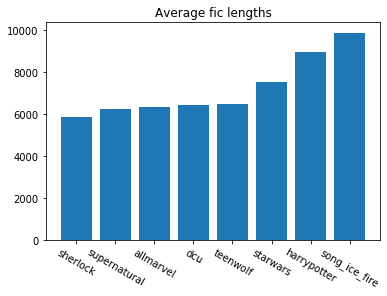

In [7]:
import matplotlib.pyplot as plt

plt.title("Average fic lengths")
plt.bar(labels, values)
plt.xticks(rotation=-30)
plt.show()

In [ ]:
# Fandom story age

## Perhaps more interesting...

In [9]:
metadata[fandom]['category']

0        ["Gen"]                                
1        ["Multi"]                              
2        ["Gen"]                                
3        ["M/M"]                                
4        ["F/F"]                                
5        ["Gen"]                                
6        ["Multi", "F/M", "M/M", "Other", "F/F"]
7        ["M/M"]                                
8        ["M/M"]                                
9        ["Gen"]                                
10       ["M/M"]                                
11       ["F/M", "M/M", "Other"]                
12       ["F/M", "M/M"]                         
13       ["M/M"]                                
14       ["Gen"]                                
15       ["M/M"]                                
16       ["M/M"]                                
17       ["M/M"]                                
18       ["M/M"]                                
19       ["M/M"]                                
20       ["M/M"]    

In [31]:
# Distribution of ships, relationship types across fandoms

proportion_mm = {}

# Proportion of stories with M/M
for fandom in fandoms:
    fics_with_mm = sum(metadata[fandom]['category'].map(lambda x: 'M/M' in x))
#     fics_with_mm = sum(metadata[fandom]['category'].map(lambda x: 'F/F' in x))
#     fics_with_mm = sum(metadata[fandom]['category'].map(lambda x: 'Other' in x))
    proportion_mm[fandom] = fics_with_mm/len(metadata[fandom])
    
proportion_mm

{'allmarvel': 0.47835236541598697,
 'dcu': 0.3677397432059611,
 'harrypotter': 0.47198827247543296,
 'sherlock': 0.6023044217687075,
 'starwars': 0.382001970587162,
 'song_ice_fire': 0.145094645150483,
 'supernatural': 0.6187985977490181,
 'teenwolf': 0.725180280515465}

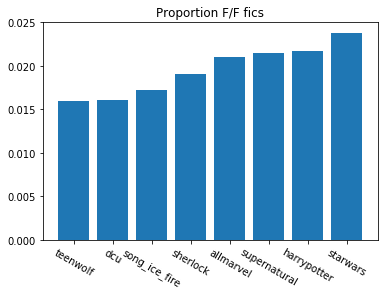

In [23]:
import operator

sorted_proportions = sorted(proportion_mm.items(), key=operator.itemgetter(1))
labels, values = list(zip(*sorted_proportions))

plt.title("Proportion F/F fics")
plt.bar(labels, values)
plt.xticks(rotation=-30)
plt.show()

In [28]:
# Do fandoms with LGBTQ ships use more LGBTQ labels?
lgbtq_labels = ['transgender', 'trans', 'queer', 'lesbian', 'gay', 'homosexual', 'nonbinary', 'non-binary']
cishet_labels = ['heterosexual', 'cisgender', 'cis']

# Count terms
word_totals = {}
lgbtq_term_counts = {fandom: {} for fandom in fandoms} # fandom: term

for fandom in tqdm(fandoms):
    word_totals[fandom] = 0
    for term in lgbtq_labels:
        lgbtq_term_counts[fandom][term] = 0
        for fic_id in sampled_fic_ids[fandom]:
#             lgbtq_term_counts[fandom][term] += stories[fandom][fic_id].replace('\n', ' ').count(term) # add count of term
            lgbtq_term_counts[fandom][term] += term in stories[fandom][fic_id].replace('\n', ' ').split()
#             word_totals[fandom] += len(stories[fandom][fic_id].split()) # total fandom word count
            word_totals[fandom] += 1
            
lgbtq_term_totals = {fandom: sum(lgbtq_term_counts[fandom].values()) for fandom in fandoms}
lgbtq_term_totals

lgbtq_term_proportions = {fandom: lgbtq_term_totals[fandom]/word_totals[fandom] for fandom in fandoms}
lgbtq_term_proportions

{'allmarvel': 0.012875,
 'dcu': 0.012125,
 'harrypotter': 0.016,
 'sherlock': 0.018,
 'starwars': 0.003375,
 'song_ice_fire': 0.011625,
 'supernatural': 0.01425,
 'teenwolf': 0.015}

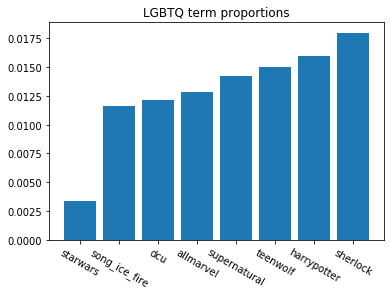

In [29]:
sorted_term_proportions = sorted(lgbtq_term_proportions.items(), key=operator.itemgetter(1))
labels, values = list(zip(*sorted_term_proportions))

plt.title("LGBTQ term proportions")
plt.bar(labels, values)
plt.xticks(rotation=-30)
plt.show()

In [32]:
# Make 2-dimensional features (proportion_mm, lgbtq_term_proportion)

x_vals = []
y_vals = []

for fandom in fandoms:
    x_vals.append(proportion_mm[fandom])
    y_vals.append(lgbtq_term_proportions[fandom])
    
print(x_vals)
print(y_vals)

[0.47835236541598697, 0.3677397432059611, 0.47198827247543296, 0.6023044217687075, 0.382001970587162, 0.145094645150483, 0.6187985977490181, 0.725180280515465]
[0.012875, 0.012125, 0.016, 0.018, 0.003375, 0.011625, 0.01425, 0.015]


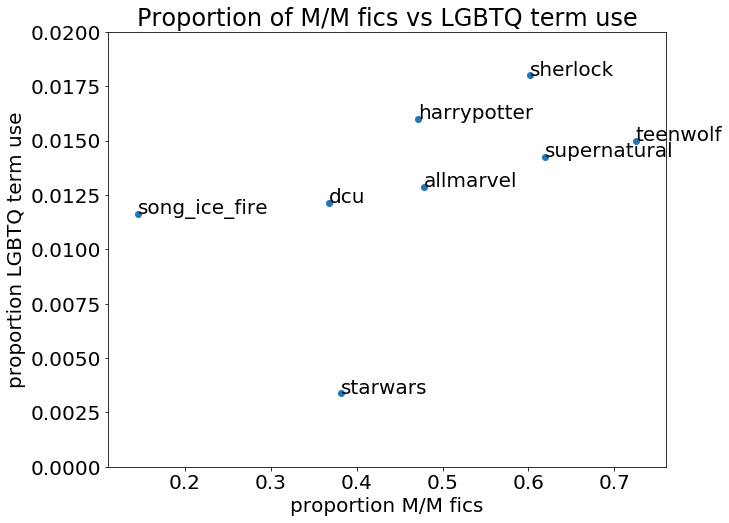

In [33]:
# Plot

font = {'size'   : 20}
plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x_vals, y_vals)

for i, fandom in enumerate(fandoms):
    ax.annotate(fandom, (x_vals[i], y_vals[i]))
plt.ylim(0, 0.02)
plt.title("Proportion of M/M fics vs LGBTQ term use")
plt.xlabel('proportion M/M fics')
plt.ylabel('proportion LGBTQ term use')
plt.show()

# Find this tutorial

https://github.com/michaelmilleryoder/fanfiction-scripts/blob/master/jupyter/fanfiction_data_visualization.ipynb

In [34]:
fandom

'teenwolf'

In [37]:
for fic_id in stories[fandom]:
    if 'gay' in stories[fandom][fic_id] and not 'bully' in stories[fandom][fic_id] and not 'closet' in stories[fandom][fic_id]:
        print(fic_id)

1666640
1319629
703385
547891
2420705
2452607
510532
11596431
11416692
12523788
886202
640283
15009425
12454968
533430
17043671
1143008
15197246
5661853
9665492
15667416
2129841
6747934
3711649
6540871
2419346
3511835
16607549
1318639
6097186
12743409
1385728
2459888
1353568
463724
3594684
5146115
935284
4488612
1058823
12052461
5145404
3179051
10067210
7097551
9531821
2378507
661887
15992984
4047142
17040794
15964658
15382959
489412
4082632
1181484
16678384
975878
4512168
8502160
12603980
